In [1]:
### If You do not have one of these packages, you can simply run: !pip install <package>

# You may also find this video helpful for permanent installations (basically installs folder to your drive)
# >> https://www.youtube.com/watch?v=ErwLcnvhW4A&t=473s

# You may also find this paper helpful for some intro information / description of optimizer algorithms
# >> https://arxiv.org/pdf/1803.08823

In [2]:
import torch
from fastai.tabular.all import *
from tqdm import tqdm

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sympy as sym
from scipy.integrate import quad
from scipy.integrate import cumulative_trapezoid

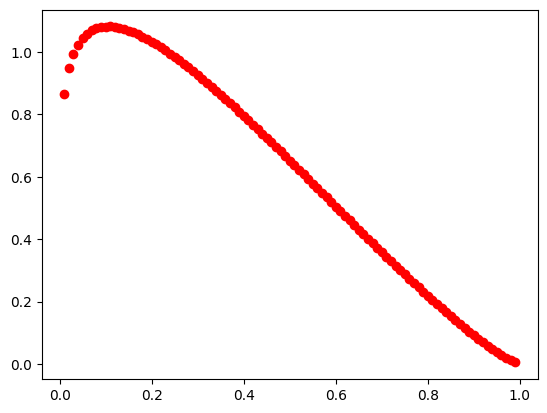

In [5]:
### Toy Model Parton Distribution Function

x = torch.arange(1,100).float()/100.

def h(x, params):

  N,a,b = params

  return N*x**a*(1-x)**b

def show(preds, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
    # ax.scatter(time, signal)
    ax.scatter(x, to_np(preds), color="red")
    plt.show()

sig_params = torch.abs(torch.randn(3)).requires_grad_()
# sig_params
signal = h(x, sig_params)
show(signal)

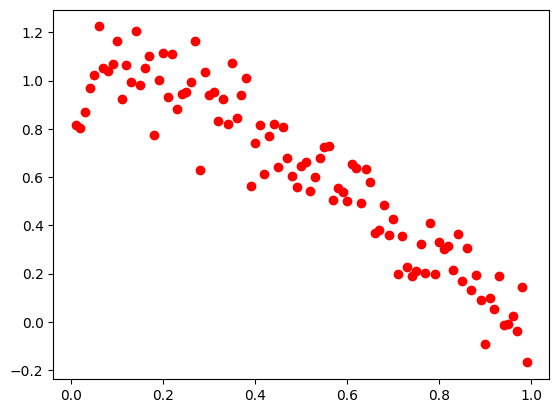

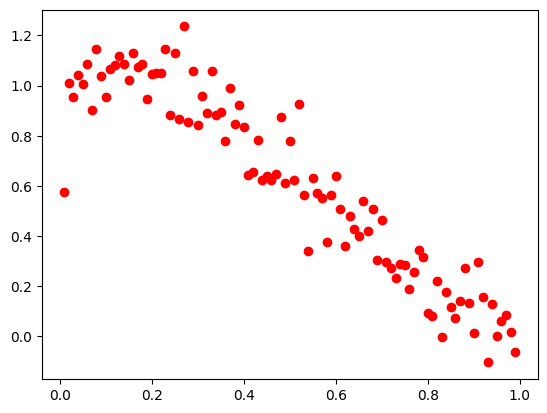

In [6]:
### Generate Data w/ Noise

# If we perform a fit with different pieces of noisey data to generate an uncertainty band \n
# This is known as the replica method (or monte carlo method) for generating uncertainty

N_train = 100
max_sig = max(signal.data)
min_sig = min(signal.data)
noise_amp = 0.1*(max_sig - min_sig)
X_train = []

for i in range(N_train):
  noise = torch.randn_like(signal)*noise_amp
  sample = signal + noise
  X_train.append(sample)

show(X_train[0])
show(X_train[30])

In [7]:
### Loss Functions

# Loss per sample
def mserr(preds, targets):
    return ((preds - targets) ** 2).mean()

# Loss per round of training (So takes in entire trainging set)
def batch_loss(preds):

  temp_loss = 0
  for i in range(N_train):

    temp_loss += mserr(preds, X_train[i])

  temp_loss /= N_train #average loss

  return temp_loss

In [8]:
# I like to seperate different parts of the code w/ empty cells.

In [9]:
##### DNN Regression

In [40]:
##### Define Model for Collinear Modulation

### NN = NN(x, q_type); q_type is quark type (modulate pdf for each quark type to prouce g_1T)
### For moderate x, restrict to just valence (up and down)

### Need to normalize to N >> But N is a parameter? I guess just choose N = 1

### NN Definition

class MLPcondensed(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super().__init__()
        self.layers = nn.Sequential(
            # Specify layers, followed by activation for that layer
            # What if you want different activations for different nodes?
            # When would that ^ be desireable?
            nn.Linear(nInput, nHidden),
            #nn.Sigmoid(),
            nn.LeakyReLU(),
            #nn.ReLU(),
            #nn.Tanh(),
            nn.Linear(nHidden, nHidden),
            #nn.Sigmoid(),
            nn.LeakyReLU(),
            #nn.ReLU(),
            #nn.Tanh(),
            nn.Linear(nHidden, nHidden),
            #nn.Sigmoid(),
            nn.LeakyReLU(),
            #nn.ReLU(),
            #nn.Tanh(),
            nn.Linear(nHidden, nOutput)
        )

    def forward(self, x):
        return(self.layers(x))

    # def forward(self, zL, zh, hadron, lambda_bar):
    #     return(self.layers(zL, zh, hadron, lambda_bar))

### 2 input x, q_type
mlpCondensed = MLPcondensed(1,3,1)
DNN_model_1 = mlpCondensed

In [41]:
### Loss Function

def mse_f(preds, targets):

    # preds = model(x)

    return ((preds - targets) ** 2).mean()

def batch_loss(preds):

    loss = 0

    for n in range(N_train):

        targets = X_train[n]
        loss += ((preds - targets) ** 2).mean()

    return loss / N_train

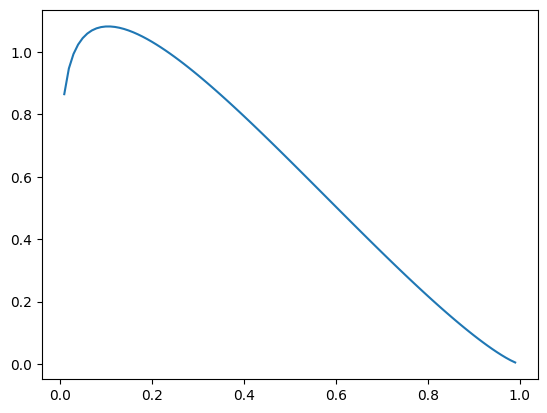

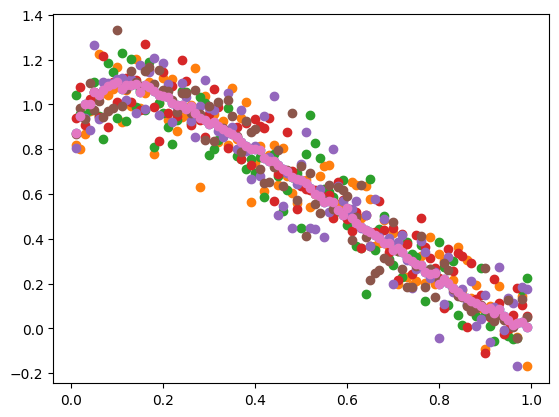

In [42]:
### Plot Central Values

# Just to see how the average data (the true function, if you like) compares across the entire set

plt.figure(0)
plt.plot(x.data, h(x, sig_params).data)


### Plot scattered central values

plt.figure(1)

avg_rep = torch.zeros(len(x))

for n in range(N_train):

    avg_rep += X_train[n]

avg_rep /= N_train

plt.scatter(x.data, avg_rep.data)
for i in range(5): plt.scatter(x.data, X_train[i].data)

plt.scatter(x.data, avg_rep.data)

In [43]:
# This is necessary for DNN_model_1 to serve as an input to our model

x_input = torch.reshape(x, (len(x), 1))

# Ex:
DNN_model_1(x_input).squeeze()

tensor([0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225,
        0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225, 0.1225,
        0.1225, 0.1226, 0.1226, 0.1226, 0.1226, 0.1226, 0.1226, 0.1226, 0.1226,
        0.1226, 0.1226, 0.1226, 0.1226, 0.1226, 0.1226, 0.1226, 0.1226, 0.1226,
        0.1226, 0.1226, 0.1226, 0.1226, 0.1226, 0.1226, 0.1226, 0.1226, 0.1221,
        0.1215, 0.1209, 0.1203, 0.1196, 0.1190, 0.1184, 0.1178, 0.1172, 0.1165,
        0.1159, 0.1153, 0.1147, 0.1141, 0.1135, 0.1128, 0.1122, 0.1116, 0.1110,
        0.1104, 0.1097, 0.1091, 0.1085, 0.1079, 0.1071, 0.1064, 0.1057, 0.1049,
        0.1042, 0.1034, 0.1027, 0.1020, 0.1012, 0.1005, 0.0998, 0.0990, 0.0983,
        0.0976, 0.0968, 0.0961, 0.0953, 0.0946, 0.0939, 0.0931, 0.0924, 0.0917,
        0.0909, 0.0902, 0.0894, 0.0887, 0.0883, 0.0883, 0.0883, 0.0883, 0.0883],
       grad_fn=<SqueezeBackward0>)

In [44]:
### Organize data into batches
xObs = x
yObs = X_train[0]

for i in range(1, len(X_train)):

    xObs = torch.cat((xObs, x))
    yObs = torch.cat((yObs, X_train[i]))

In [45]:
### Organize Training Data

### They want to use Dataloaders in batches of 25 training points
### Apparently networks learn better this way

class nonLinearRegressionData(Dataset): #Dataset comes with some nice methods
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, xObs, yObs):

        # Reshape I think because need them to be matrices for network input
        self.xObs = torch.reshape(xObs, (len(xObs), 1))
        self.yObs = torch.reshape(yObs, (len(yObs), 1))

    def __len__(self):
        return(len(self.xObs))

    def __getitem__(self, idx):
        return(xObs[idx], yObs[idx])

# instantiate Dataset object for current training data
d = nonLinearRegressionData(xObs, yObs)

print(d)

train_dataloader = DataLoader(d, batch_size=10 , shuffle=True)

In [16]:
##### Train

In [46]:
### Train
from tqdm import tqdm

# Define the loss function and optimizer
mlpCondensed = MLPcondensed(1,10,1)
DNN_model = mlpCondensed
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(DNN_model.parameters(), lr=1e-2)
nTrainSteps = 30
#nTrainSteps = 60

def training():
  # Track loss over epochs
  track_loss = np.zeros(nTrainSteps)

  # Run the training loop
  for epoch in tqdm(range(0, nTrainSteps)):

    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_dataloader, 0):

      # Get inputs
      inputs, targets = data

      # Zero the gradients
      optimizer.zero_grad()

      # Perform forward pass (make sure to supply the input in the right way)
      outputs = DNN_model(torch.reshape(inputs, (len(inputs), 1))).squeeze()

      # Compute loss
      loss = loss_function(outputs, targets)

      # Perform backward pass
      loss.backward(retain_graph = True)

      # Perform optimization
      optimizer.step()

      track_loss[epoch] = loss.item()

  return track_loss

# Process is complete.
print('Training process has finished.')

Training process has finished.


100%|██████████| 30/30 [02:04<00:00,  4.15s/it]


[0.00815274 0.02350718 0.0108994  0.01115011 0.00868492 0.01693366
 0.00482321 0.00787485 0.01862547 0.01351015 0.00926645 0.0079777
 0.00209541 0.01178514 0.01602477 0.01139895 0.00919123 0.00803063
 0.01045285 0.00627295 0.00817041 0.02209212 0.00617374 0.00544959
 0.00778422 0.00712037 0.0077354  0.0086254  0.0094077  0.00672489]


100%|██████████| 30/30 [02:01<00:00,  4.05s/it]


[0.01084915 0.00668839 0.0198664  0.00486974 0.00946021 0.01528571
 0.01151881 0.01021258 0.02753611 0.01091504 0.00853721 0.01834131
 0.01020349 0.00898408 0.01522928 0.02111856 0.00559215 0.02119368
 0.02143621 0.00762522 0.0203823  0.01518604 0.01108436 0.01447673
 0.01304238 0.01756976 0.0151248  0.01132545 0.01328514 0.00595524]


100%|██████████| 30/30 [02:02<00:00,  4.07s/it]


[0.01133027 0.01154564 0.00890969 0.00727628 0.00749551 0.00851841
 0.00509448 0.01137439 0.01011604 0.01154344 0.01155194 0.02668831
 0.00732498 0.00859378 0.00657779 0.00614221 0.00813709 0.01757784
 0.00757518 0.00866974 0.009012   0.00830155 0.00867979 0.01292228
 0.01374661 0.01093198 0.0181004  0.03188825 0.01170238 0.01395056]


100%|██████████| 30/30 [02:01<00:00,  4.05s/it]


[0.00527869 0.00558634 0.00539635 0.01490465 0.00346031 0.01659077
 0.00786791 0.00768039 0.00592023 0.00657857 0.00795148 0.0142549
 0.01117136 0.01284097 0.01099363 0.01186318 0.01032603 0.00654994
 0.01464267 0.00846974 0.02165573 0.01240403 0.01793681 0.00987977
 0.01424298 0.01365494 0.02322998 0.00396685 0.01220614 0.0132774 ]


100%|██████████| 30/30 [01:57<00:00,  3.92s/it]


[0.02107407 0.00781288 0.00962746 0.00915718 0.00808402 0.00745619
 0.01790671 0.00532743 0.01858152 0.0099058  0.00775347 0.00738294
 0.02193932 0.01207209 0.01197116 0.01074272 0.01408102 0.0025665
 0.01127677 0.01151151 0.01412384 0.00650978 0.01530049 0.00675704
 0.00379821 0.01534117 0.01676416 0.01367714 0.00830311 0.0229343 ]


100%|██████████| 30/30 [01:57<00:00,  3.92s/it]


[0.01314902 0.01204934 0.00764425 0.00894609 0.0150243  0.01507209
 0.0061789  0.00785053 0.01187404 0.00904829 0.00988804 0.0087251
 0.00675355 0.01930431 0.00433023 0.00308766 0.01607647 0.00899234
 0.01932916 0.00329173 0.01648745 0.0088905  0.01128609 0.00413774
 0.00697782 0.01749041 0.01213221 0.00747815 0.00535062 0.01181098]


100%|██████████| 30/30 [01:59<00:00,  3.99s/it]


[0.00765693 0.01487282 0.01094217 0.00666701 0.01815172 0.01072093
 0.01519582 0.01493637 0.00663103 0.00806564 0.00239311 0.0118968
 0.00730965 0.01610787 0.0194801  0.00739805 0.00984587 0.01647234
 0.00574108 0.00970789 0.01339077 0.01927494 0.01980191 0.00567173
 0.01225963 0.00934294 0.00833525 0.01009668 0.01522575 0.00566984]


100%|██████████| 30/30 [01:59<00:00,  3.99s/it]


[0.01092191 0.03919328 0.0124372  0.02395072 0.01102331 0.0115919
 0.01031837 0.01720927 0.01328261 0.02101379 0.02292374 0.01053882
 0.00859002 0.00323331 0.01212889 0.01165588 0.02060745 0.00525517
 0.01300669 0.01315097 0.00718149 0.00459622 0.01465914 0.00863362
 0.00375181 0.01788295 0.01377463 0.00527056 0.00655425 0.0246463 ]


100%|██████████| 30/30 [02:00<00:00,  4.00s/it]


[0.00429063 0.00547706 0.00895279 0.02060939 0.00758571 0.00833165
 0.02478352 0.01823149 0.01221907 0.01920726 0.02170488 0.01966624
 0.00661871 0.00745051 0.01432346 0.01464492 0.01011127 0.00569424
 0.01208785 0.01272122 0.01028832 0.00804805 0.01314162 0.00394702
 0.01293392 0.00845577 0.01643615 0.007727   0.01044829 0.01457463]


100%|██████████| 30/30 [01:59<00:00,  4.00s/it]

[0.00713296 0.01319674 0.01427544 0.00846681 0.01661631 0.00958435
 0.00939526 0.00952169 0.00795214 0.00842063 0.01787011 0.01266843
 0.02165056 0.02221691 0.00822983 0.00754802 0.01320447 0.01439558
 0.00940943 0.00465638 0.0102921  0.01211612 0.00759013 0.0311235
 0.01257082 0.00531266 0.02410738 0.00294836 0.00954369 0.00221201]


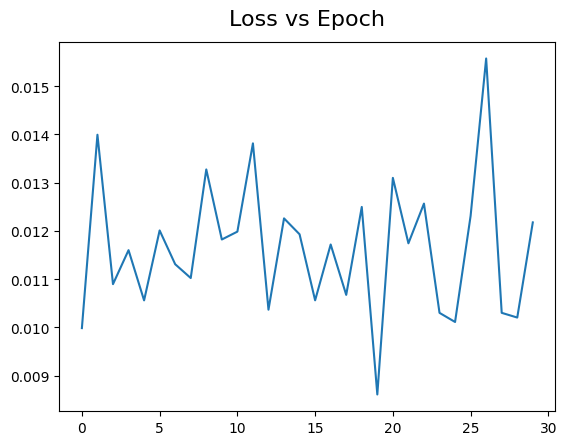

In [47]:
done_losses = {} #dictionary
numIters = 10
for i in range(0,numIters):
  results_of_iteration = training() #gets current array
  print(results_of_iteration)
  for j in range(0,nTrainSteps):
    if j in done_losses:
      done_losses[j] += results_of_iteration[j]
    else:
      done_losses[j] = results_of_iteration[j]

average_losses = [0]*nTrainSteps
for i in range(0,nTrainSteps):
  average_losses[i] = done_losses[i]/numIters

plt.figure(0)
plt.title("Loss vs Epoch", fontsize = 16, pad = 12)
plt.plot(np.arange(nTrainSteps), average_losses)

In [ ]:
### I find it useful to plot how the loss evolves during training

# This can tell you if we plateau rapidly, etc

plt.figure(0)
plt.title("Loss vs Epoch", fontsize = 16, pad = 12)
plt.plot(np.arange(nTrainSteps), track_loss)

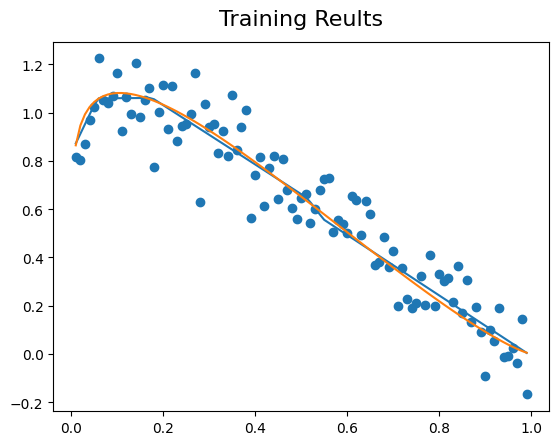

In [48]:
### Plot model results, true signal, and noisey data point

plt.figure()
plt.title("Training Reults", fontsize = 16, pad = 12)
plt.plot(x.data, DNN_model(x_input).squeeze().data, label = 'DNN Fit')
plt.plot(x.data, h(x, sig_params).data, label = 'True PDF')
plt.scatter(x.data, X_train[0].data)